In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from constants import country_mappings, blue_palette, blue_inverted, region_mappings, month_mapping
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import set_credentials_file
import os
import dateutil
from datetime import datetime

set_credentials_file(username=os.environ.get('PLOTLY_USER'), api_key=os.environ.get('PLOTLY_API_KEY'))

## Introduction

Big Data for Big Sharks, because 'Small and Messy Data for Tiny, Average and Moderately Large Sized Sharks' just doesn't have the same ring to it.  Why would any want to investigate this dataset? Sharks are scary right? And the whole topic might seem a little morbid?  But often it's more important to try and understand things we're afraid of and if we learn the most from the data that we can, it can uncover interesting information that will help us to coexist with these important members of the ocean ecosystem. Plus, as a budding surfer, I don't want to get put off going in the ocean by the hype of newspapers after any attack.  So put on your data scientist hats, let's go for a dive.

<img width=50% src="https://cdn4.lostateminor.com/wp-content/uploads/2013/08/Sharks-human-teeth-6-830x620.jpg"/>

## Get the data
Load the 'Global Shark Attacks' dataset.  This dataset is a 'great' example of semi-structured, free-form text based set up, perfect for demonstrating various types of data cleaning, aggregation and standarisation. Fun fact: Experts say that 'attacks' is a misnomer and most interactions should be classified as 'encounters' since having a feed was probably not on the shark's agenda.

In [2]:
data = pd.read_csv("../../datasets/attacks.csv", encoding='latin1')
data.head(5)

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson?McNeely,F,...,Sand shark,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299,NaN,NaN


In [3]:
# how much data do we have? 
print(data.shape)

# Not exactly huge!

(6302, 24)


## Begin the EDA
Look at: 
<p>1) What data is available e.g. column names?</p>
<p>2) How much of it is invalid/missing? Can any of this be retrieved from elsewhere? </p> 
<p>3) Check other data hygiene e.g. spelling errors in place names (Westerm vs Western)</p>
<p>4) Get plotting! Make some hypotheses and measure them - e.g fatal vs non-fatal encounters, most likely activity during fatal encounter, most likely place of encounter. What kind of story are we trying to tell and see whether the data lends itself to that.</p>
<p>5) Are there other datasets that would be useful to investigate in addition to this one, e.g. tourism shark sightings or weather data? (maybe sharks like storms!)</p>
<p>6) Look at the results. Do they make sense? Question your own biases and perspectives to come up with ways that the data might tell a different story, depending on how you look at it. This is important because if opposite conclusions can be drawn then maybe you need to dig a bit deeper. What pieces could be missing to fill in the whole picture?</p>

In [4]:
data.columns

Index(['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22',
       'Unnamed: 23'],
      dtype='object')

In [5]:
# grab the useful looking columns for now (and watch out for spaces/punctuation in the titles!)
cols = ['Case Number','Date', 'Time', 'Type', 'Species ', 'Country', 'Area', 'Location', 'Activity', 'Sex ', 'Age', 'Fatal (Y/N)']
data_useful_cols = data[cols]
data_useful_cols.head()

,Case Number,Date,Time,Type,Species,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N)
0,2018.06.25,25-Jun-2018,18h00,Boating,White shark,USA,California,"Oceanside, San Diego County",Paddling,F,57,N
1,2018.06.18,18-Jun-2018,14h00 -15h00,Unprovoked,Sand shark,USA,Georgia,"St. Simon Island, Glynn County",Standing,F,11,N
2,2018.06.09,09-Jun-2018,07h45,Invalid,NaN,USA,Hawaii,"Habush, Oahu",Surfing,M,48,N
3,2018.06.08,08-Jun-2018,NaN,Unprovoked,2 m shark,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,M,NaN,N
4,2018.06.04,04-Jun-2018,NaN,Provoked,"Tiger shark, 3m",MEXICO,Colima,La Ticla,Free diving,M,NaN,N


In [6]:
# now for some hygiene measurements - how much of each column is missing?
# for the most part, everything is there, only Species, Age and Time are partially complete 
# (note that attacks prior to some year in the 1900s don't have times associated)
# for c in cols:
#     print(f"{c}: {round(data_useful_cols[c].count()/data_useful_cols.shape[0]*100, 2)}% complete")

data_useful_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6302 entries, 0 to 6301
Data columns (total 12 columns):
Case Number    6301 non-null object
Date           6302 non-null object
Time           2983 non-null object
Type           6298 non-null object
Species        3432 non-null object
Country        6252 non-null object
Area           5847 non-null object
Location       5762 non-null object
Activity       5758 non-null object
Sex            5741 non-null object
Age            3475 non-null object
Fatal (Y/N)    5777 non-null object
dtypes: object(12)
memory usage: 590.9+ KB


In [7]:
data_with_species = data_useful_cols.dropna(subset=["Species "])
species = data_with_species['Species '].unique()
print(f"There are {data_with_species.shape[0]} entries with species named")
print(f"There are currently {len(species)} species listed")
print(species[:15])

# printing some of the species shows that quite a few also describe the length as well, 
# so might be worth doing a bit of regex to clean that up
test = data_with_species['Species '].loc[data_with_species['Species '] == 'Tiger shark, 3m']
print(test)

There are 3432 entries with species named
There are currently 1540 species listed
['White shark' 'Sand shark' '2 m shark' 'Tiger shark, 3m' 'Unknown'
 'Tiger shark' "Lemon shark, 3'" "Bull shark, 6'" 'Grey reef shark'
 'Invalid incident' 'Tawny nurse shark, 2m'
 'Shark involvement not confirmed' 'Questionable' '3 m shark'
 'White shark, 3.5 m']
4      Tiger shark, 3m
821    Tiger shark, 3m
Name: Species , dtype: object


In [8]:

class SpeciesDataInvestigator():
    def __init__(self, species):
        self.species = species
        self.size_count = 0
        self.matches_existing_count = 0
        self.no_inv_conf = 0
        self.some_known_ones = ['white ', 'tiger', 'sandtiger', 'sand shark', 'cookie', 'nurse', 'blue shark', 'lemon', 'wobbegong', 'bull',
                  'porbeagle', 'galapagos', 'spinner', 'blacktip', 'whitetip', 'whale', 'macrurus',
                  'hammerhead', 'shovelnose', 'mako', 'thresher', 'basking', 'black tipped', 'copper', 'dusky',
                  'grey reef', 'leucas', 'sevengill', 'raggedtooth', 'goblin', 'salmon', 'cow', 'silky',
                  'dogfish', 'river', 'angel', 'zambesi', 'gray', 'zambezi', 'caribbean', 'sandbar', 'brown', 
                  'maculpinnis', 'leopard', 'carpet', 'dog', 'silvertip', 'smooth', 'port jackson', 'blue pointer']
        
        self.scientific_mapping = {'shovelnose': 'bull', 'white ': 'great white', 'smooth': 'smoothhound','leucas': 'bull', 'macrurus': 'dusky', 'cookie': 'cookiecutter', 'whale': 'bronze whaler',
                     'nurse': 'grey nurse', 'carpet': 'wobbegong', 'zambezi': 'bull', 'zambesi': 'bull',
                      'black tipped': 'blacktip', 'raggedtooth': 'grey nurse', 'copper': 'bronze whaler',
                     'sand shark': 'grey nurse', 'brown': 'sandbar', 'maculpinnis': 'spinner', 'dog': 'spurdog',
                                  'blue pointer': 'mako', 'cow': 'sevengill'}

        self.species_count_dict = {} # how many different ways each species type is mentioned

        self.spinner_blacktip_mismatch = 0
        self.species_confusion = 0
        self.multi_match = []

    def get_corrected_species(self, s):
        match = [w for w in self.some_known_ones if w in s.lower().replace('-','').replace('7','seven')]
        if len(match) > 1:
            self.matches_existing_count += 1

            # this exploration lead to a couple of interesting findings that relied on expert knowledge
            # 1) grey nurse sharks and grey reef sharks are totally different species
            # 2) blacktips and spinners look almost identical but they are different species
            # 3) tiger sharks and sandtigers are also different!
            # print("multi matches: ", match, s)
            if 'tiger' in match and 'sandtiger' in match:
                self.matches_existing_count += 1
                self.species_count_dict['grey nurse'] = self.species_count_dict.get('grey nurse', 0) + 1
                return 'grey nurse'
            elif 'spinner' in match and 'blacktip' in match:
                # self.spinner_blacktip_mismatch += 1
                self.species_count_dict['multi_match'] = self.species_count_dict.get('multi_match', 0) + 1
                self.species_confusion += 1
                return 'multi'
            else:
                # self.species_confusion += 1
                self.species_count_dict['multi_match'] = self.species_count_dict.get('multi_match', 0) + 1
                self.multi_match += match
                return 'multi'
        elif len(match) == 1:
            self.matches_existing_count += 1
            common = self.scientific_mapping.get(match[0], match[0]) # either get the common name match from the dict
                                                                # or just return the match name itself
            self.species_count_dict[common] = self.species_count_dict.get(common, 0) + 1
            return common
        elif any([w in s.lower() for w in ['unconfirmed', 'not a', 'drowning','involvement', 'invovl', 'invalid', 'questionable', 'eel']]):
            self.no_inv_conf += 1
            #species_count_dict['unconfirmed_incident'] = species_count_dict.get("unconfirmed", 0) + 1
            return 'unconfirmed'
        else:
            #print(s)
            self.species_count_dict['unknown'] = self.species_count_dict.get('unknown', 0) + 1
            return 'unknown'

    def print_details(self):
        print(f"{self.matches_existing_count} of the {len(self.species)} species are from the known species list, indicating \
        a whole bunch of duplicates. E.g. tiger shark, 3m != tiger shark, 6m")
        print(f"{self.no_inv_conf} were variations of unconfirmed encounters or suggested no shark involvement")
        print(f"In {self.species_confusion} cases, there were several species suspected")
        print("Breakdown of shark encounter counts per species: ")
        print(self.species_count_dict)
#     else:
#         print(s)
#         res = re.search("\d+(\.\d+)?\s?m", s)
#         if res:
#             size_count += 1


# use whole dataset - make new species_corrected column
# data_useful_cols = data_useful_cols.assign(species_corrected=data_useful_cols['Species '].copy())
corrected_species = pd.Series(data_useful_cols['Species '].copy())

# if species is na, put 'missing' in species_corrected
# data_useful_cols['species_corrected'].fillna('missing', inplace=True)
corrected_species.fillna('unknown', inplace=True)

# if species matches in the following process, put new species label in species_corrected
investigator = SpeciesDataInvestigator(species)

for s in species:
    corrected = investigator.get_corrected_species(s)
    if corrected == 'multi':
        if 'spinner' in s:
            investigator.spinner_blacktip_mismatch += corrected_species.loc[corrected_species == s].count()
        investigator.species_confusion += corrected_species.loc[corrected_species == s].count()
    
    corrected_species.loc[corrected_species == s] = corrected
    
#print(f"{size_count} of the {len(species)} species have sizes in metres")
investigator.print_details()

1115 of the 1540 species are from the known species list, indicating         a whole bunch of duplicates. E.g. tiger shark, 3m != tiger shark, 6m
44 were variations of unconfirmed encounters or suggested no shark involvement
In 84 cases, there were several species suspected
Breakdown of shark encounter counts per species: 
{'great white': 296, 'grey nurse': 112, 'unknown': 395, 'tiger': 124, 'lemon': 26, 'bull': 108, 'grey reef': 11, 'wobbegong': 33, 'galapagos': 4, 'blue shark': 25, 'cookiecutter': 2, 'spinner': 16, 'porbeagle': 7, 'blacktip': 44, 'whitetip': 24, 'sevengill': 16, 'smoothhound': 2, 'caribbean': 12, 'angel': 2, 'multi_match': 55, 'mako': 39, 'bronze whaler': 56, 'silky': 4, 'hammerhead': 37, 'goblin': 2, 'sandbar': 11, 'salmon': 2, 'port jackson': 1, 'thresher': 4, 'spurdog': 5, 'dusky': 12, 'gray': 4, 'basking': 1, 'leopard': 2, 'silvertip': 2}


In [9]:
# add it to the existing data as a new column
data_useful_cols = data_useful_cols.assign(corrected_species=corrected_species)
data_useful_cols.head(10)

,Case Number,Date,Time,Type,Species,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),corrected_species
0,2018.06.25,25-Jun-2018,18h00,Boating,White shark,USA,California,"Oceanside, San Diego County",Paddling,F,57,N,great white
1,2018.06.18,18-Jun-2018,14h00 -15h00,Unprovoked,Sand shark,USA,Georgia,"St. Simon Island, Glynn County",Standing,F,11,N,grey nurse
2,2018.06.09,09-Jun-2018,07h45,Invalid,NaN,USA,Hawaii,"Habush, Oahu",Surfing,M,48,N,unknown
3,2018.06.08,08-Jun-2018,NaN,Unprovoked,2 m shark,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,M,NaN,N,unknown
4,2018.06.04,04-Jun-2018,NaN,Provoked,"Tiger shark, 3m",MEXICO,Colima,La Ticla,Free diving,M,NaN,N,tiger
5,2018.06.03.b,03-Jun-2018,NaN,Unprovoked,Unknown,AUSTRALIA,New South Wales,"Flat Rock, Ballina",Kite surfing,M,NaN,N,unknown
6,2018.06.03.a,03-Jun-2018,Late afternoon,Unprovoked,Tiger shark,BRAZIL,Pernambuco,"Piedade Beach, Recife",Swimming,M,18,Y,tiger
7,2018.05.27,27-May-2018,NaN,Unprovoked,"Lemon shark, 3'",USA,Florida,"Lighhouse Point Park, Ponce Inlet, Volusia County",Fishing,M,52,N,lemon
8,2018.05.26.b,26-May-2018,17h00,Unprovoked,"Bull shark, 6'",USA,Florida,"Cocoa Beach, Brevard County",Walking,M,15,N,bull
9,2018.05.26.a,26-May-2018,14h00,Unprovoked,NaN,USA,Florida,"Daytona Beach, Volusia County",Standing,M,12,N,unknown


In [10]:
corrected_species.value_counts()

unknown          3910
great white       612
unconfirmed       502
tiger             251
bull              207
grey nurse        175
bronze whaler      80
blacktip           71
multi              69
wobbegong          58
mako               56
hammerhead         47
blue shark         39
lemon              34
whitetip           30
spinner            22
sevengill          22
grey reef          17
caribbean          16
dusky              14
sandbar            11
spurdog             7
porbeagle           7
galapagos           7
angel               6
basking             6
thresher            4
silky               4
gray                4
salmon              3
leopard             2
smoothhound         2
goblin              2
cookiecutter        2
silvertip           2
port jackson        1
Name: Species , dtype: int64

In [11]:
data_useful_cols['Location'].fillna('Unknown', inplace=True)
data_useful_cols['Type'].fillna('Unknown', inplace=True)
river_mask = data_useful_cols['Location'].str.lower().str.contains('river')
non_beach_mask = data_useful_cols['Location'].str.lower().str.contains('beach')
non_surfing_mask = data_useful_cols['corrected_activity'].str.lower().str.contains('surfing')
valid_only_mask = data_useful_cols['Type'].str.lower().str.contains('invalid')
bull_shark_imputation = data_useful_cols.loc[~valid_only_mask].loc[river_mask].loc[~non_beach_mask].loc[~non_surfing_mask].loc[data_useful_cols['corrected_species'] == 'unknown']
print(f'{bull_shark_imputation.shape[0]} potential bull shark encounters')
non_river_mouth = data_useful_cols['Location'].str.lower().str.contains('mouth')
bull_shark_imputation_2 = bull_shark_imputation.loc[~non_river_mouth]
print(f"{bull_shark_imputation_2.shape[0]} almost certain bull shark encounters, bringing the bull shark encounters to {bull_shark_imputation_2.shape[0] + corrected_species.value_counts()['bull']}")

KeyError: 'corrected_activity'

In [32]:
# replace missing ages with -1
data_useful_cols['Age'].fillna(-1, inplace=True)

In [33]:
# Fix the countries (can't believe these aren't unique and standardised :/)
corrected_countries = pd.Series(data_useful_cols['Country'].copy())
# data_useful_cols[pd.isnull(data_useful_cols['Country'])]

# replace nans with 'missing' - only about 50 (could convert location if available, 
# but might not be worth the effort)
corrected_countries.fillna('UNKNOWN', inplace=True)

# remove spaces and question marks from countries first
corrected_countries = corrected_countries.str.replace('(^\s+|\?|\s+$)', '')

# some known fixes - e.g. Sri Lanka, Andaman Islands
for key, item in country_mappings.items():
    corrected_countries[corrected_countries == key] = item

countries = data_useful_cols['Country'].unique()
# find duplicates with upper and lower case
for country in countries:
    match = [country for c in countries if str(c).lower() == str(country).lower()]
    if len(match) > 1:
        corrected_countries.loc[corrected_countries == match[0]] = country.upper()
        corrected_countries.loc[corrected_countries == match[1]] = country.upper() 

print(len(corrected_countries.unique()))
#print(corrected_countries.unique())

161


In [34]:
country_counts = []
for c in corrected_countries.unique():
    # print(f'{c}:', corrected_countries.loc[corrected_countries == c].count())
    country_counts.append(corrected_countries.loc[corrected_countries == c].count())
total_count = corrected_countries.shape[0]

sort = sorted(zip(country_counts, corrected_countries.unique()), reverse=True)
counts, countries = zip(*sort)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

region_labels = list(set([v['region'] for v in region_mappings.values()]))
print(region_labels)
region_counts = {}
# for every country in the corrected_countries list, if they are in region r, add to count
skip_count = 0
for c in corrected_countries:
    try:
        key = region_mappings[c]['region']
    except:
        key = c
    region_counts[key] = region_counts.get(key, 0) + 1

# investigating how many of Hawaii's encounters contribute to the 'North America' pile erroneously:
hawaii_count = data_useful_cols.loc[corrected_countries == 'USA']['Area'].str.contains('Hawaii', case=False).value_counts()
print(f"{hawaii_count[1]} of the {hawaii_count[0] + hawaii_count[1]} USA encounters are from Hawaii")

region_counts['NORTH AMERICA'] = region_counts['NORTH AMERICA'] - hawaii_count[1]

region_counts['NORTH PACIFIC'] = region_counts['NORTH PACIFIC'] + hawaii_count[1]

sort_region = sorted(zip(region_counts.values(), region_counts.keys()), reverse=True)
counts_reg, regions = zip(*sort_region)

print(dict(zip(regions, counts_reg)))

['NORTH ATLANTIC', 'SOUTH AMERICA', 'CARIBBEAN', 'NORTH PACIFIC', 'NORTH AMERICA', 'SOUTHERN AFRICA', 'SOUTH PACIFIC', 'ASIA', 'CENTRAL AMERICA', 'INDIAN OCEAN', 'NORTHERN AFRICA', 'MEDITERRANEAN SEA', 'CENTRAL AFRICA', 'EUROPE', 'MIDDLE EAST', 'SOUTH ATLANTIC']
298 of the 2225 USA encounters are from Hawaii
{'NORTH AMERICA': 1944, 'SOUTH PACIFIC': 1843, 'SOUTHERN AFRICA': 644, 'NORTH PACIFIC': 329, 'ASIA': 274, 'CARIBBEAN': 268, 'EUROPE': 265, 'SOUTH AMERICA': 160, 'CENTRAL AMERICA': 159, 'MIDDLE EAST': 122, 'INDIAN OCEAN': 94, 'NORTHERN AFRICA': 53, 'UNKNOWN': 51, 'PACIFIC OCEAN': 19, 'ATLANTIC OCEAN': 17, 'SOUTH ATLANTIC': 14, 'NORTH ATLANTIC': 13, 'CENTRAL AFRICA': 11, 'MEDITERRANEAN SEA': 10, 'MID ATLANTIC OCEAN': 5, 'CENTRAL PACIFIC': 3, 'AFRICA': 2, 'OCEAN': 1, 'BAHRAIN': 1}


In [35]:
# country_labels = []
# for i in range(8):
#     country_labels.append(f'{countries[i]}\n({round(counts[i]/total_count*100, 1)})')
# patches, texts = ax.pie(counts[:8], 
#                          labels=country_labels, 
#                          labeldistance=1.2, 
#                          #pctdistance=1.1, 
#                          #autopct='%.1f%%', 
#                          startangle=90, 
#                          colors=blue_inverted, 
#                          wedgeprops={'linewidth': 1, 'edgecolor': 'black'})

# for t in texts:
#     t.set_horizontalalignment('center')
# plt.show()

In [36]:
# make a nicer one in Plotly
num_to_show = 9
vals = list(counts[:num_to_show])
vals.append(sum(counts[num_to_show:]))
labels = list(countries[:num_to_show])
labels.append('REST OF WORLD')
vals_reg = list(counts_reg[:num_to_show])
vals_reg.append(sum(counts_reg[num_to_show:]))
labels_reg = list(regions[:num_to_show])
labels_reg.append('OTHER')
fig = {
  "data": [
    {
      "values": vals,
      "labels": labels,
      "domain": {"x": [0, .48]},
      "name": "Shark Encounters",
      "hoverinfo":"label+percent+value",
      "hole": .4,
      "type": "pie",
      "marker": dict(colors=blue_inverted, 
                           line=dict(color='#000000', width=2))
    }, 
    {
      "values": vals_reg,
      "labels": labels_reg,
      "domain": {"x": [.52, 1]},
      "name": "Shark Encounters",
      "hoverinfo":"label+percent+value",
      "hole": .4,
      "type": "pie",
      "marker": dict(colors=blue_inverted, 
                           line=dict(color='#000000', width=2))
    }],
  "layout": {
        "title":"Shark Encounters By Country and By Region",
        "annotations": [
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "By Country",
                "x": 0.17,
                "y": 0.5
            },
            {
                "font": {
                    "size": 20
                },
                "showarrow": False,
                "text": "By Region",
                "x": 0.83,
                "y": 0.5
            }
        ]
        
    }
}
py.iplot(fig)

# Note here about the proportions: Geographically Hawaii is in the North Pacific rather than North America
# so splitting the data along those lines would almost certainly change the 'By Region' distribution quite
# significantly. Will take a look at that at some point


# Naturally, the South Pacific percentage goes up since 3 of the top 10 are in the South Pacific (Aus, NZ, New Guinea)


In [37]:
# fix up the dates - make sure they're in dd-mmm-yyyy format (pick 1st of month of unknown days)
year = pd.Series(data_useful_cols['Date'].copy())
month = pd.Series(data_useful_cols['Date'].copy())
day = pd.Series(data_useful_cols['Date'].copy())

In [38]:
def try_parsing_date(text):

    for fmt in ('%d-%b-%Y', '%d %b %Y', '%b %Y', '%b-%Y', '%B %Y', '%B-%Y'):
        try:
            new_date = datetime.strptime(text, fmt)
            # print(new_date)
            return new_date.day, new_date.month, new_date.year
        except ValueError:
            pass
    return -1, -1, -1


def date_fixer(date, idx):
    if '--' in date:
        date = date.replace("--", "-")
        
    #if date.endswith('s') or date.endswith('?'):
    if re.search('^.*?(s|\?)(\s*)$', date):
        
        date = date.replace('s','').replace('?','')

    date = date.split('.')[0]
    
    if re.search('(^No date$|^Ca\s*$|^\s*$)', date):
        return -1, -1, -1
    
    date = date.split("Reported ")[-1].strip()
    # try:
        # date_fix = dateutil.parser.parse(date, default=datetime(2016, 6, 1, 0, 0), fuzzy=True)
    day, month, year = try_parsing_date(date)
    if day == -1 and month == -1 and year == -1:
    #except:
        years = [int(y) for y in re.findall('\d{4}', date)]
        if len(years) > 0:
            new_year = round(abs(years[0] - years[-1])/2) + years[0]
        else:
            new_year = -1

        months = re.findall('(Jan|Feb|Mar|Ap|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)', date)
        if len(months) > 0:
            new_month = round(abs(month_mapping[months[-1]] - month_mapping[months[0]])/2) + month_mapping[months[-1]]
            if new_month > 12:
                new_month = new_month - 12
        else:
            new_month = -1
        
        return -1, new_month, new_year
    else:
        return day, month, year
        

broken_date_count = 0
for i in range(data_useful_cols['Date'].shape[0]):
    #if not re.search('(\d+)?(-|\s)?[A-Za-z]+-\d+', d):
    # print(f"{d}:{date_fixer(d)}")
    date = data_useful_cols['Date'][i]
    
    corrected_date = date_fixer(date, i)
    if corrected_date:
        try:
            year[i] = corrected_date[2]
            month[i] = corrected_date[1]
            day[i] = corrected_date[0]
        except:
            print('broken', corrected_date)
    else: 
        
        # print(date)
        broken_date_count += 1

print(broken_date_count)


0


In [39]:
month.value_counts()

 7     669
 8     603
 9     554
-1     520
 1     518
 6     500
 4     457
 10    447
 12    439
 3     413
 11    406
 5     394
 2     382
Name: Date, dtype: int64

In [40]:
data_useful_cols = data_useful_cols.assign(year=year, month=month, day=day, corrected_country=corrected_countries)


In [41]:
country_codes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')
additional_codes = {
    "Reunion": "ROU",
    "St Helena": "SHN",
    "Cape Verde": "CPV",
    "Bahamas": "BHS",
    "New Guinea": "PNG",
    "Trinidad & Tobago": "TTO",
    "Diego Garcia": "IOT",
    "Palestinian Territories": "PSE",
    "Antigua": "ATG",
    "Turks & Caicos": "TCA",
    "Azores": "PTL", # (Portugal)
    "South Korea": "KOR",
    "Nevis": "KNA",
    "Micronesia": "FSM",
    "Johnston Island": "UMI",
    "Admiralty Islands": "PNG", # or AY
    "Andaman Islands": "IND", # (India)
    "Mayotte": "MYT",
    "Martinique": "MTQ", 
    "St. Martin": "MAF"
}

country_code = pd.Series(corrected_countries.copy())
for c in corrected_countries.unique():
    if c == 'USA':
        new_c = 'United States'
    elif 'micronesia' in c:
        new_c = '"Micronesia, Federated States of"'
    else:
        new_c = c
        
    code = country_codes.loc[country_codes['COUNTRY'] == new_c.title()]['CODE']
    if code.count() == 0:
        try:
            code = additional_codes[new_c.title()]
        except:
            code = None
            # print(f"No code available for {new_c.title()}, skipping...")
    else:
        code = code.iloc[0]
    # update the new country code column to contain the actual code (or -1 for missing codes, e.g. oceans)
    country_code.loc[country_code == c] = code

country_code.head(15)
code_counts = []
for c in country_code.unique():
    code_counts.append(country_code.loc[country_code == c].count())
#print([v for v in country_code.value_counts()])

In [42]:

data = [ dict(
        type = 'choropleth',
        locations = country_code.unique(),
        z = code_counts,
        # text = corrected_countries.unique(),
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Number of encounters'),
      ) ]

layout = dict(
    title = 'Shark Encounters per Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

# Some figures for reference
# USA coastal population (i.e. those living within 50km of the coast) = 39% of 325 mil ~ 126 mil
# Aus coastal population = 85% of 25 mil ~ 21 mil
# Approx 6x more people on the coast in USA compared to Aus but only 2x as many encounters.

In [43]:
# tidy up the activities column - it is totally messy with all sorts of random weird descriptions of what
# people were doing. I don't really like the find and replace method as a long term solution, but it
# works for now as a quick way of aggregating more meaning from the data and hopefully finding better patterns

print(f"Currently, {len(data_useful_cols['Activity'].value_counts())} unique activities")
top_val = 20
print(f"Top {top_val} are: \n{data_useful_cols['Activity'].value_counts()[:top_val]}, accounting for {data_useful_cols['Activity'].value_counts()[:top_val].sum()} of the entries\n")

aggregated_activities = pd.Series(data_useful_cols['Activity'].copy())
aggregated_activities = aggregated_activities.fillna('Unknown')
diving = aggregated_activities.str.lower().str.contains('diving')
diving.value_counts() # at least 578 activities contain 'diving'
aggregated_activities.loc[diving] = 'Diving'

surfing = aggregated_activities.str.lower().str.contains('surfing')
# print(surfing.value_counts()) # at least 1127 activities contain 'surfing' of some description
aggregated_activities.loc[surfing] = 'Surfing'

kayak = aggregated_activities.str.lower().str.contains('kayak')
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('canoe')] = 'Kayaking' # 13 odd entries
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('rowing')] = 'Kayaking' # 12 odd entries
# print(kayak.value_counts()) # at least 61 activities contain 'kayak' of some description
aggregated_activities.loc[kayak] = 'Kayaking'

wading = aggregated_activities.str.lower().str.contains('wading')
# print(wading.value_counts()) # at least 175 activities contain 'wading' of some description
aggregated_activities.loc[wading] = 'Wading'

boarding = aggregated_activities.str.lower().str.contains('boarding')
# print(boarding.value_counts()) # at least 148 activities contain 'boarding' of some description
aggregated_activities.loc[boarding] = 'Boarding (Body, Boogie, etc)'

swimming = aggregated_activities.str.lower().str.contains('swimming')
# print(swimming.value_counts()) # at least 1096 activities contain 'swimming' of some description
aggregated_activities.loc[swimming] = 'Swimming'
   
skiing = aggregated_activities.str.lower().str.contains('skiing')
# print(skiing.value_counts()) # at least 41 activities contain 'skiing' of some description
aggregated_activities.loc[skiing] = 'Surf skiing'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('fell')] = 'Went Overboard'
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('overboard')] = 'Went Overboard'
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('jump')] = 'Went Overboard'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('disaster')] = 'Sea Disaster'
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('wreck')] = 'Sea Disaster'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('floating')] = 'Floating'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('surfboard')] = 'Surfing'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('spearfishing')] = 'Spearfishing'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('boat')] = 'Sailing'
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('sailing')] = 'Sailing'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('playing')] = 'Playing In Water'
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('splashing')] = 'Playing In Water'

aggregated_activities.loc[aggregated_activities.str.lower().str.contains('tagging')] = 'Shark Interactions'
aggregated_activities.loc[aggregated_activities.str.lower().str.contains('feeding')] = 'Shark Interactions'

aggregated_activities.loc[aggregated_activities.str.contains('Fishing')] = "Fishing" # some have spaces :/

bottom_random_garbage_activities = aggregated_activities.value_counts()[top_val:]
# print(f"\nRemainder: {bottom_random_garbage_activities}")

for k in aggregated_activities.value_counts()[top_val:].keys():
    aggregated_activities[aggregated_activities == k] = "Other"
    
# my favourite activities from this list so far:
# 1) Escaping from Alcatraz and 2) Riding a horse and 3) Testing anti-shark cage

print(f"New Activities List is: \n{aggregated_activities.value_counts()}")


Currently, 1531 unique activities
Top 20 are: 
Surfing            971
Swimming           869
Fishing            431
Spearfishing       333
Bathing            162
Wading             149
Diving             127
Standing            99
Snorkeling          89
Scuba diving        76
Body boarding       61
Body surfing        49
Swimming            47
Kayaking            33
Pearl diving        32
Treading water      32
Fell overboard      32
Boogie boarding     29
Free diving         29
Windsurfing         19
Name: Activity, dtype: int64, accounting for 3669 of the entries

New Activities List is: 
Surfing                         1150
Swimming                        1092
Other                            648
Fishing                          578
Diving                           578
Unknown                          547
Spearfishing                     385
Wading                           175
Bathing                          162
Went Overboard                   151
Boarding (Body, Boogie, etc)    

In [44]:
corrected_sex = pd.Series(data_useful_cols['Sex '].fillna('U')) # for unknown
corrected_sex.value_counts() # even this is pretty garbage! Also interesting the massive skew towards men (5000 vs 600 ladies), 
# though, given that the highest ranked activity is surfing, maybe it isn't so surprising

corrected_sex.loc[corrected_sex == 'M '] = 'M'
corrected_sex.loc[corrected_sex == 'N'] = 'M'
mask = corrected_sex[corrected_sex != 'U'][corrected_sex != 'M'][corrected_sex != 'F']
for m in mask:
    corrected_sex[corrected_sex == m] = 'U'

In [45]:
corrected_sex.value_counts() 
data_useful_cols = data_useful_cols.assign(corrected_sex=corrected_sex)

In [46]:
age = data_useful_cols['Age']
mask_nan = age.str.isnumeric().fillna(False)
age[~mask_nan] = -1
age.value_counts()
data_useful_cols['Age'] = age

/home/jdp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [47]:
data_useful_cols = data_useful_cols.assign(corrected_activity=aggregated_activities)

In [48]:
# lastly clean up the fatality column
# data_useful_cols.info()
# 5777 of the 6302 entries have values
corrected_fatality = pd.Series(data_useful_cols['Fatal (Y/N)'].copy())
corrected_fatality[corrected_fatality == 'Y'] = 2
corrected_fatality.loc[corrected_fatality == 'y'] = 2
corrected_fatality[corrected_fatality == 'N'] = 0
corrected_fatality.loc[corrected_fatality == ' N'] = 0
corrected_fatality.loc[corrected_fatality == 'N '] = 0
corrected_fatality.loc[corrected_fatality == 'M'] = 0

total_fatal = data_useful_cols['Fatal (Y/N)'].loc[data_useful_cols['Fatal (Y/N)'] == 'Y'].count()
total_non_fatal = data_useful_cols['Fatal (Y/N)'].loc[data_useful_cols['Fatal (Y/N)'] == 'N'].count()
print('Fatal encounters', len(corrected_fatality[corrected_fatality == 2]), total_fatal)
print('Non-Fatal encounters', len(corrected_fatality[corrected_fatality == 0]), total_non_fatal)
print(f'{5777 - total_fatal - total_non_fatal} entries that are something other than Y/N')
print(f'{6302 - 5777} entries that are blank')
blank_or_messy = data_useful_cols.loc[data_useful_cols['Fatal (Y/N)'] != 'Y'].loc[data_useful_cols['Fatal (Y/N)'] != 'N']
blank_or_messy.loc[~pd.isnull(blank_or_messy["Fatal (Y/N)"])]

# if the event was considered invalid or boating related, 
# then put a -1 in the fatality column since it was neither 
# (as opposed to 'N' which indicated an encounter happened but wasn't fatal.)
corrected_fatality[data_useful_cols['Type'] == 'Invalid'] = -1
corrected_fatality[data_useful_cols['Type'] == 'Boat'] = -1
corrected_fatality[data_useful_cols['Type'] == 'Boating'].loc[data_useful_cols['corrected_species'] == 'unknown'] = -1

# check again - why use the full dataset columns? Because often the rows are shifted and the columns land in the wrong spot (in this case, the Time column)
data_useful_cols[['Fatal (Y/N)','Time']].loc[corrected_fatality != 1].loc[corrected_fatality != 0].loc[corrected_fatality != -1].head(10)

corrected_fatality[data_useful_cols['Time'] == 'N'] = 0
corrected_fatality[data_useful_cols['Time'] == 'Y'] = 2

# All the remaining ones appear to be either unknown or empty so will fill those with a 'maybe' value
# data_useful_cols.loc[corrected_fatality != 2].loc[corrected_fatality != 0].loc[corrected_fatality != -1]

corrected_fatality[corrected_fatality == 'UNKNOWN'] = 1
corrected_fatality = corrected_fatality.fillna(1)

print(corrected_fatality.value_counts())


Fatal encounters 1385 1384
Non-Fatal encounters 4259 4250
143 entries that are something other than Y/N
525 entries that are blank
 0    4171
 2    1377
-1     673
 1      81
Name: Fatal (Y/N), dtype: int64


In [49]:
data_useful_cols = data_useful_cols.assign(corrected_fatality=corrected_fatality)

In [50]:
fda_in_aus = data_useful_cols.loc[data_useful_cols['corrected_fatality'] == 2].loc[data_useful_cols['corrected_country'] == 'AUSTRALIA']
# print(fatalities_during_activities)
activities_aus = data_useful_cols.loc[data_useful_cols['corrected_country'] == 'AUSTRALIA']['corrected_activity'].value_counts()
for k, v in fda_in_aus['corrected_activity'].value_counts().items():
    print(f"{k}: {round(v/activities_aus[k]*100)}%")
# fairly similar distribution to the rest of the world, except floating! Almost a 3 fold increase, but upon
# investigation, there were only 3 instances of floating in the Aus dataset, 2 fatal, and one misclassified
# as floating (he was in a rubber raft, oops)

fda_in_aus.loc[fda_in_aus['corrected_activity'] == 'Floating']

Swimming: 40.0%
Diving: 27.0%
Other: 25.0%
Bathing: 40.0%
Surfing: 9.0%
Went Overboard: 65.0%
Unknown: 13.0%
Fishing: 7.0%
Spearfishing: 8.0%
Sailing: 23.0%
Sea Disaster: 71.0%
Wading: 19.0%
Boarding (Body, Boogie, etc): 14.0%
Snorkeling: 10.0%
Floating: 67.0%
Standing: 18.0%
Treading water: 33.0%
Kayaking: 6.0%


,Case Number,Date,Time,Type,Species,Country,Area,Location,Activity,Sex,Age,Fatal (Y/N),corrected_species,corrected_sex,corrected_activity,corrected_fatality,corrected_country,day,month,year
3140,1977.08.23,23-Aug-1977,NaN,Unprovoked,NaN,AUSTRALIA,Queensland,"Buddina Beach, south of Noosa",Floating on an inflatable raft,M,25,Y,unknown,M,Floating,2,AUSTRALIA,23,8,1977
5160,1925.11.22,22-Nov-1925,15h15,Unprovoked,"Tiger shark, 4 m [13'] female",AUSTRALIA,Western Australia,Cottesloe Beach,Floating on his back,M,55,Y,tiger,M,Floating,2,AUSTRALIA,22,11,1925


In [51]:
fatalities_during_activities = data_useful_cols.loc[data_useful_cols['corrected_fatality'] == 2]['corrected_activity'].value_counts()
# print(fatalities_during_activities)
for k, v in fatalities_during_activities.items():
    print(f"{k}: {round(v/aggregated_activities.value_counts()[k]*100)}%")
# wowsers, sea disasters and falling overboard seem to be the most hazardous and even swimming is up there
# despite the majority of incidences happening while people surf, only 6% are fatal

Swimming: 37.0%
Other: 30.0%
Diving: 22.0%
Unknown: 19.0%
Went Overboard: 64.0%
Bathing: 44.0%
Fishing: 12.0%
Surfing: 6.0%
Sailing: 35.0%
Spearfishing: 12.0%
Sea Disaster: 65.0%
Kayaking: 17.0%
Boarding (Body, Boogie, etc): 14.0%
Wading: 10.0%
Standing: 16.0%
Snorkeling: 12.0%
Floating: 20.0%
Treading water: 22.0%
Playing In Water: 7.0%


In [52]:
aus = data_useful_cols.loc[data_useful_cols['corrected_country'] == 'AUSTRALIA'].loc[data_useful_cols['year'] > 1968]['corrected_species'].loc[data_useful_cols['corrected_species'] != 'unconfirmed'].value_counts()
print(f"Summary of responsible sharks, Australia:\n{aus}")
print(f"For a total of {aus.sum()}\n")

hawaii = data_useful_cols.loc[data_useful_cols['corrected_country'] == 'USA'].loc[data_useful_cols['Area'] == 'Hawaii'].loc[data_useful_cols['year'] > 1968]['corrected_species'].loc[data_useful_cols['corrected_species'] != 'unconfirmed'].value_counts()
print(f"Summary of responsible sharks, Hawaii\n{hawaii}")
print(f"For a total of {hawaii.sum()}\n")

print(f"Summary of responsible sharks, Florida\n{data_useful_cols.loc[data_useful_cols['corrected_country'] == 'USA'].loc[data_useful_cols['Area'] == 'Florida'].loc[data_useful_cols['year'] > 1968]['corrected_species'].loc[data_useful_cols['corrected_species'] != 'unconfirmed'].value_counts()}")
print("\n")
florida = data_useful_cols.loc[data_useful_cols['corrected_country'] == 'USA'].loc[data_useful_cols['Area'] == 'Florida'].loc[data_useful_cols['year'] > 1968]['corrected_species'].loc[data_useful_cols['corrected_species'] != 'unconfirmed'].value_counts().sum()
locations = data_useful_cols.loc[data_useful_cols['corrected_country'] == 'USA'].loc[data_useful_cols['Area'] == 'Florida'].loc[data_useful_cols['year'] > 1968].loc[data_useful_cols['corrected_species'] != 'unconfirmed']

locations['Location'] = locations['Location'].fillna('no location')
who_dun_it = locations.loc[locations['Location'].str.contains('Volusia County')]

# Looks like more people have been bitten by wobbegongs than tiger sharks in Australia! Wow!

print(f'Number one shark destination is clearly Florida, with {florida} attacks in the last 50 years! With {who_dun_it.shape[0]} in Volusia County\n')

print(f"\nTop 10 locations in Florida: \n{locations['Location'].value_counts()[:10]}\n")
print(f"Responsible species in Volusia: \n{who_dun_it['corrected_species'].value_counts()}\n")
print(f"The multi species options: \n{who_dun_it['Species '].loc[who_dun_it['corrected_species'] =='multi']}\n")
# Shows that it's uniformly spinner or blacktips who are the culprit

print(f"Top 10 activities: \n{who_dun_it['Activity'].value_counts()[:10]}\n")
print(f"And whether they were fatal or not? \n{who_dun_it['corrected_fatality'].value_counts()}")


Summary of responsible sharks, Australia:
unknown          258
great white      112
bronze whaler     44
wobbegong         30
tiger             24
bull              23
grey nurse        15
mako               5
multi              4
sevengill          4
hammerhead         4
whitetip           3
blacktip           3
grey reef          2
leopard            1
port jackson       1
blue shark         1
sandbar            1
dusky              1
cookiecutter       1
gray               1
lemon              1
Name: corrected_species, dtype: int64
For a total of 539

Summary of responsible sharks, Hawaii
unknown         103
tiger            82
whitetip          4
galapagos         2
hammerhead        2
grey reef         1
cookiecutter      1
great white       1
blacktip          1
Name: corrected_species, dtype: int64
For a total of 197

Summary of responsible sharks, Florida
unknown        643
bull            40
grey nurse      28
blacktip        27
multi           26
spinner         21
lemon    

In [53]:
year_buckets = range(1948, 2018, 10)
fatalities = data_useful_cols.loc[data_useful_cols['corrected_fatality'] == 2]
year_counts = []
aus_year_counts = []
for y in year_buckets:
    year_counts.append(fatalities.loc[fatalities['year'] > y].loc[fatalities['year'] < y + 10]['corrected_country'].value_counts()[:5])
    aus_year_counts.append(fatalities.loc[fatalities['year'] > y].loc[fatalities['year'] < y + 10][fatalities['corrected_country'] == 'AUSTRALIA']['Area'].value_counts())
# most_deadly = data_useful_cols.loc[data_useful_cols['corrected_fatality'] == 2].loc[data_useful_cols['year'] > 2008]['corrected_country'].value_counts()[:10]
# print(most_deadly)
# most_dangerous_spot_in_aus = data_useful_cols.loc[data_useful_cols['corrected_fatality'] == 2].loc[data_useful_cols['year'] > 2008].loc[data_useful_cols['corrected_country'] == 'AUSTRALIA']
# # most_dangerous_spot_in_aus
# print(year_counts)



/home/jdp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [54]:
top_five_set = list(set([k for y in year_counts for k in y.keys()]))
print(top_five_set)
print(len(top_five_set))
# make stacks for the bar graph thingo
# print([str(y+1) + '-' + str(y+5) for y in year_buckets])

['USA', 'MEXICO', 'TANZANIA', 'SOUTH AFRICA', 'NEW CALEDONIA', 'AUSTRALIA', 'CHINA', 'MOZAMBIQUE', 'NEW GUINEA', 'BRAZIL', 'GREECE', 'PHILIPPINES', 'VANUATU', 'REUNION']
14


In [55]:
import colorlover as cl
from IPython.display import HTML

colour_set = []
# print(len(cl.scales['11']['div']['PiYG']))
colour_set.extend(cl.scales['11']['div']['Spectral'])
colour_set = cl.scales['11']['div']['PiYG'][2:4] + colour_set
colour_set.extend(cl.scales['11']['div']['RdGy'][-4:-2])
print(len(colour_set))

15


In [56]:
traces = []
x = [str(y+1) + '-' + str(y+10) for y in year_buckets] # e.g. '2014-2018'

for i in range(len(top_five_set)):
    c = top_five_set[i]
    colour = colour_set[i]
    traces.append(go.Bar(
        x=x,
        y=[y.get(c) for y in year_counts],
        name=c.title(),
        marker=dict(color= colour)
    ))

data = traces
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [57]:
traces = []
x = [str(y+1) + '-' + str(y+10) for y in year_buckets] # e.g. '2014-2018'

aus_set = list(set([k for y in aus_year_counts for k in y.keys()]))

for i in range(len(aus_set)):
    c = aus_set[i]
    colour = colour_set[i]
    traces.append(go.Bar(
        x=x,
        y=[y.get(c) for y in aus_year_counts],
        name=c.title(),
        marker=dict(color= colour)
    ))

data = traces
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [58]:
data_useful_cols.loc[data_useful_cols['corrected_country'] == "AUSTRALIA"].loc[data_useful_cols['year'] > 1988]['corrected_fatality'].value_counts()

 0    369
-1     57
 2     44
 1      8
Name: corrected_fatality, dtype: int64

In [59]:
# Checking out some colour schemes
# HTML(cl.to_html( cl.scales['11']['div'] ))

In [60]:
hemisphere = pd.Series(data_useful_cols['corrected_country'].copy())
for c in hemisphere.unique():
    
    try:
        hemi = region_mappings[c]['hemisphere']
    except KeyError as e:
        if c == "UNKNOWN":
            hemi = 'U'
        else:
            hemi = 'C' # meaning central or both
    
    hemisphere[hemisphere == c] = hemi
            

print(hemisphere.value_counts())
data_useful_cols = data_useful_cols.assign(hemisphere=hemisphere)


N    3600
S    2559
C      92
U      51
Name: corrected_country, dtype: int64


In [61]:
# does it look like seasons have a part to play?

months_north = data_useful_cols.loc[data_useful_cols['hemisphere'] == 'N'].loc[data_useful_cols['month'] != -1]['month'].value_counts()
months_south = data_useful_cols.loc[data_useful_cols['hemisphere'] == 'S'].loc[data_useful_cols['month'] != -1]['month'].value_counts()

seasons_counter = {'north': {'summer': 0, 'winter': 0, 'spring': 0, 'autumn': 0},
                   'south': {'summer': 0, 'winter': 0, 'spring': 0, 'autumn': 0}
                  }

totals = {'north': months_north.sum(), 'south': months_south.sum()}

for m, v in months_south.items():
    if m == 12 or m < 3:
        seasons_counter['south']['summer'] += v
    elif m >= 3 and m < 6:
        seasons_counter['south']['autumn'] += v
    elif m >= 6 and m < 9:
        seasons_counter['south']['winter'] += v
    else:
        seasons_counter['south']['spring'] += v

for m, v in months_north.items():
    if m == 12 or m < 3:
        seasons_counter['north']['winter'] += v
    elif m >= 3 and m < 6:
        seasons_counter['north']['spring'] += v
    elif m >= 6 and m < 9:
        seasons_counter['north']['summer'] += v
    else:
        seasons_counter['north']['autumn'] += v

for k, h_dict in seasons_counter.items():
    print(f"Percentages for {k}")
    for key, val in h_dict.items():
        print(f"{key}: {round(val/totals[k]*100)}%")
        
print(seasons_counter)
print(months_south.sum())



Percentages for north
summer: 42.0%
winter: 11.0%
spring: 20.0%
autumn: 27.0%
Percentages for south
summer: 40.0%
winter: 15.0%
spring: 20.0%
autumn: 25.0%
{'north': {'summer': 1385, 'winter': 344, 'spring': 637, 'autumn': 895}, 'south': {'summer': 970, 'winter': 356, 'spring': 478, 'autumn': 598}}
2402


### Blacktip shark migration - leave the north during the cold months (like all of autumn, winter and spring lol)
Main time it looks too cold to swim in Florida is the dead of winter, spring and autumn still look fine and given that it's too cold to swim in NC, this could explain why there is a fairly equal distribution acros summer, spring and autumn in Florida.

#### For Florida
Summer: 35.0% <br/>
Winter: 7.0%<br/>
Spring: 26.0%<br/>
Autumn: 32.0%<br/><br/>
Aug      128 - summer<br/>
July     117 - summer<br/>
June     108 - summer<br/>
Apr      107 - spring<br/>
Oct      100 - autumn<br/>
May      91 - spring<br/>
Mar      62 - spring<br/>
Nov      55 - autumn<br/>
Feb      26 - winter<br/>
Dec      20 - winter<br/>
Jan      19 - winter<br/>

#### For North Carolina
Summer: 75.0%<br/>
Winter: 2.0%<br/>
Spring: 3.0%<br/>
Autumn: 20.0%<br/>
<br/>
Aug      26<br/>
June     16<br/>
Sept     14<br/>
Oct      4<br/>
May      3<br/>
Dec      1<br/>
Nov      1<br/>
Feb      1<br/>

#### Comparing Brisbane and Perth
Temperatures throughout the year are almost identical

WA: (180??)
summer: 31.0%
winter: 16.0%
spring: 32.0%
autumn: 22.0%

Queensland: (302)
summer: 43.0%
winter: 12.0%
spring: 25.0%
autumn: 21.0%

NSW: (468)
summer: 48.0%
winter: 9.0%
spring: 18.0%
autumn: 25.0%

In [41]:
# Visualisation ideas for the future
# 0) graph how the fatalities across the world change per year
# 1) geographical plots showing encounters/year and any trajectories between encounters (e.g. moving south/north)
# 2) pie chart per region showing which shark was most likely involved in the encounter
# 3) include weather data
# 4) include sightings data and tracking data where available

## Modelling Time!
Now for some predictions. Things to try:
1) PCA on features to determine which are most important for predicting shark encounter fatality
2) From the 1039 unidentified sharks, predict what they likely are


In [42]:
# Check again what we have to work with
print(data_useful_cols.columns)
print(data_useful_cols['Type'].unique()) # probably skip this column for now
print(len(data_useful_cols['Area'].unique())) # skip area and location just for the first pass since there are
                                            # 826 options for area which haven't been processed or 
                                            # aggregated in any way, even more for Location. These would almost
                                            # certainly be of interest though


data_final_cols = data_useful_cols.loc[data_useful_cols['corrected_fatality'] != -1][['Age', 'corrected_sex', 'corrected_species', 'corrected_country', 
                                    'corrected_activity', 'year', 'month', 'hemisphere']]
labels = data_useful_cols['corrected_fatality'].loc[data_useful_cols['corrected_fatality'] != -1]

Index(['Case Number', 'Date', 'Time', 'Type', 'Species ', 'Country', 'Area',
       'Location', 'Activity', 'Sex ', 'Age', 'Fatal (Y/N)',
       'corrected_species', 'corrected_country', 'day', 'month', 'year',
       'corrected_sex', 'corrected_activity', 'corrected_fatality',
       'hemisphere'],
      dtype='object')
['Boating' 'Unprovoked' 'Invalid' 'Provoked' 'Questionable' 'Sea Disaster'
 nan 'Boat' 'Boatomg']
826


In [121]:
labels.shape

(5629,)

In [43]:
data_final_cols.head(10)

,Age,corrected_sex,corrected_species,corrected_country,corrected_activity,year,month,hemisphere
0,57,F,great white,USA,Other,2018,6,N
1,11,F,grey nurse,USA,Standing,2018,6,N
3,-1,M,unidentified,AUSTRALIA,Surfing,2018,6,S
4,-1,M,tiger,MEXICO,Diving,2018,6,N
5,-1,M,unidentified,AUSTRALIA,Surfing,2018,6,S
6,18,M,tiger,BRAZIL,Swimming,2018,6,S
7,52,M,lemon,USA,Fishing,2018,5,N
8,15,M,bull,USA,Other,2018,5,N
9,12,M,unknown,USA,Standing,2018,5,N
10,32,M,grey reef,AUSTRALIA,Shark Interactions,2018,5,S


In [44]:
encoded_data = pd.get_dummies(data_final_cols, columns=['corrected_sex', 'corrected_species', 'corrected_country', 'corrected_activity', 'hemisphere'], sparse=False)


In [45]:
encoded_data.head()

,Age,year,month,corrected_sex_F,corrected_sex_M,corrected_sex_U,corrected_species_angel,corrected_species_basking,corrected_species_blacktip,corrected_species_blue shark,...,corrected_activity_Surfing,corrected_activity_Swimming,corrected_activity_Treading water,corrected_activity_Unknown,corrected_activity_Wading,corrected_activity_Went Overboard,hemisphere_C,hemisphere_N,hemisphere_S,hemisphere_U
0,57,2018,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,11,2018,6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-1,2018,6,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,-1,2018,6,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,-1,2018,6,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [46]:
print(encoded_data.shape, labels.shape)

(5629, 223) (5629,)


In [62]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

train_data = np.array(encoded_data, dtype=float)
train_labels = np.array(labels, dtype=float)
print(train_data.shape, train_labels.shape)
train_x, test_x, train_y, test_y = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape)

(5629, 223) (5629,)
(4503, 223) (4503,)


In [180]:
# find out which one performs the best from the outset
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    # GaussianProcessClassifier(1.0 * RBF(1.0)), # loses efficiency in higher dimensions (> dozens)
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
]

for name, clf in zip(names, classifiers):

    clf.fit(train_x, train_y)
    score = clf.score(test_x, test_y)

    print(f"{name}: {score}")


Nearest Neighbors: 0.7593250444049734
Linear SVM: 0.7584369449378331
RBF SVM: 0.7593250444049734
Gaussian Process: 0.7726465364120781
Decision Tree: 0.7548845470692718
Random Forest: 0.7841918294849023
Neural Net: 0.7868561278863233
AdaBoost: 0.30106571936056836


As a fun comparison between models out of the box with no tweaking, they all perform fairly averagely (i.e poorly!). Realistically, I was not expecting much at all given that neither the area nor the location were included, and particularly for the countries, the data would have been incredibly sparse (i.e. about 160 countries and some with only 1-2 incidents), ditto for the species. Removing the invalid incidents from the list of data gave each model a 2-5% increase in accuracy, which makes sense given a) there is less data to generalise over and b) those were quite conflating pieces of data that could very well have seemed like one of the other classes.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition
from sklearn import datasets

def three_dee_pca_plotter(data_for_training, labels_for_training, label_names_vals):
    """ Plot the top 3 principle components of a training dataset
        Args:
            data_for_training: a numpy array containing training data
            labels_for_training: a numpy array containing the numerical labels for the training data
            label_names_vals: a list of tuples containing the label in format (text form, numerical form)
                for example: [('Non-fatal', 0.0), ('Unknown', 1.0), ('Fatal', 2.0)]
        
        Returns:
            Nil - plots the 3D graph of principle components for the dataset

    """
    np.random.seed(5)

    centers = [[1, 1], [-1, -1], [1, -1]]

    fig = plt.figure(1, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

    plt.cla()
    pca = decomposition.PCA(n_components=3)
    pca.fit(data_for_training)
    X = pca.transform(data_for_training)

    for name, label in label_names_vals:
        ax.text3D(X[labels_for_training == label, 0].mean(),
                  X[labels_for_training == label, 1].mean() + 1.5,
                  X[labels_for_training == label, 2].mean(), name,
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

    # Reorder the labels to have colors matching the cluster results
    y = np.choose(labels_for_training.astype(np.int64), [1.0, 0.0, 2.0])#.astype(np.float)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral,
               edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])

    plt.show()


PCA shows not a whole lot of variance between the principle components, suggesting that the current features
as they are don't have a lot of discriminative power. Next steps would be to a) include different features from the dataset (e.g. area and location), b) include better analysis of the species data - extract size where possible, c) tweak the better performing model(s) to try and improve performance or d) try a more powerful model - recent advanced in DL for structured data are pretty interesting - particularly representing categorical variables as dense embeddings rather than sparse one-hot-encodings which do nothing to capture any kind of semantic relationships between features (e.g. some shark species are similar to each other, geographical locations as well and certainly activities too).

In [249]:
# try with less features - drop age and sex and drop the label 'Unknown' - only use Fatal (2) or Non-fatal (0)
experiment_2 = data_useful_cols.loc[data_useful_cols['corrected_fatality'] != -1].loc[data_useful_cols['corrected_fatality'] != 1][[ 'corrected_species', 'corrected_country', 
                                    'corrected_activity', 'year', 'month', 'hemisphere']]
labels_exp2 = data_useful_cols['corrected_fatality'].loc[data_useful_cols['corrected_fatality'] != -1].loc[data_useful_cols['corrected_fatality'] != 1]

In [275]:

one_hot_cols = pd.get_dummies(experiment_2, columns=['corrected_species', 'corrected_country', 'corrected_activity', 'hemisphere'])

exp2_train = np.array(one_hot_cols, dtype=float)
train_labels = np.array(labels_exp2, dtype=float)
print(exp2_train.shape, train_labels.shape)
exp2_train_x, exp2_test_x, exp2_train_y, exp2_test_y = train_test_split(exp2_train, train_labels, test_size=0.1, random_state=42)
print(exp2_train_x.shape, exp2_train_y.shape)

(5548, 217) (5548,)
(4993, 217) (4993,)


In [298]:
names = ["Random Forest", "Neural Net"]

classifiers = [
    RandomForestClassifier(max_depth=10, n_estimators=20, max_features=1),
    MLPClassifier(alpha=1e-2, max_iter=1000, hidden_layer_sizes=200, learning_rate='adaptive', 
                  learning_rate_init=1e-3)
]

for name, clf in zip(names, classifiers):

    clf.fit(exp2_train_x, exp2_train_y)
    score = clf.score(exp2_test_x, exp2_test_y)

    print(f"{name}: {score}")

Random Forest: 0.7855855855855856
Neural Net: 0.818018018018018


In [48]:
from keras import Sequential, Input, Model
from keras.layers import (Conv1D, MaxPooling1D, GlobalAveragePooling1D, 
                          Merge, Dropout, Dense, Embedding, Reshape, concatenate)

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import Callback


Using TensorFlow backend.
/home/jdp/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6



In [150]:
num_classes = 2
exp2_train_x_reshaped = np.expand_dims(exp2_train_x, -1)
exp2_train_y_reshaped = pd.get_dummies(exp2_train_y)
print(exp2_train_x_reshaped.shape, exp2_train_y_reshaped.shape)
model_m = Sequential()

model_m.add(Conv1D(100, 10, activation='relu', input_shape=(exp2_train_x_reshaped.shape[1], 1)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

NameError: name 'exp2_train_x' is not defined

In [299]:

# callbacks_list = [
#     ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
#         monitor='val_loss', save_best_only=True)
#     #EarlyStopping(monitor='acc', patience=1)
# ]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 300
EPOCHS = 50

history = model_m.fit(exp2_train_x_reshaped,
                      exp2_train_y_reshaped,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      # callbacks=callbacks_list,
                      validation_split=0.1,
                      #verbose=1
                     )

Train on 4493 samples, validate on 500 samples
Epoch 1/50
4493/4493 [==============================] - 4s 872us/step - loss: 0.4153 - acc: 0.7981 - val_loss: 0.4049 - val_acc: 0.7800
Epoch 2/50
4493/4493 [==============================] - 2s 515us/step - loss: 0.4155 - acc: 0.7990 - val_loss: 0.4027 - val_acc: 0.7840
Epoch 3/50
4493/4493 [==============================] - 2s 517us/step - loss: 0.4125 - acc: 0.7972 - val_loss: 0.4024 - val_acc: 0.7960
Epoch 4/50
4493/4493 [==============================] - 2s 542us/step - loss: 0.4120 - acc: 0.8001 - val_loss: 0.4013 - val_acc: 0.7880
Epoch 5/50
4493/4493 [==============================] - 2s 517us/step - loss: 0.4125 - acc: 0.8037 - val_loss: 0.4008 - val_acc: 0.7920
Epoch 6/50
4493/4493 [==============================] - 2s 518us/step - loss: 0.4123 - acc: 0.8032 - val_loss: 0.4041 - val_acc: 0.7840
Epoch 7/50
4493/4493 [==============================] - 3s 562us/step - loss: 0.4070 - acc: 0.8010 - val_loss: 0.4056 - val_acc: 0.8020
E

A more complex model (multi-layer 1D conv net) gave some moderate improvement, but mostly removing the extra class (for 'unknown' - essentially a 'maybe' for fatality) seems to have given the greatest boost. Upping the batch size appeared to help very marginally, but wouldn't consider that a robust approach. Standing by my earlier comment that better encoding the free text data and being able to include locations (as well as other related location factors, e.g. nearby hospitals or google maps terrain) would be useful in this case. Removing extra features such as age and sex had some impact too.

In [100]:
# Experiment 3 - remove date data with -1s in the month columns, use a dense representation for
# categorical variables instead of one hot encoding
class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    
    An instance of this class should be defined for each categorical variable we want to use.
    """
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value+1 for int_value, value in enumerate(values)}
        
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        
        # Else, return the same integer for unseen values
        else:
            return self.num_values

exp3_data = data_useful_cols.loc[data_useful_cols['corrected_fatality'] != -1].loc[data_useful_cols['corrected_fatality'] != 1].loc[data_useful_cols['month'] != -1][['year','month','corrected_activity', 'corrected_species', 'corrected_country', 'hemisphere', 'corrected_fatality']]
print(exp3_data.count())

cat_var_data = exp3_data[['corrected_activity', 'corrected_species', 'corrected_country', 'hemisphere']]
cont_var_data = exp3_data[['year', 'month']]
exp3_labels = exp3_data['corrected_fatality']
exp3_labels[exp3_labels == 2] = 1

cont_var_data_mean = cont_var_data.mean()
cont_var_data_std = cont_var_data.std()

cont_var_data = ( cont_var_data - cont_var_data_mean ) / cont_var_data_std
print(cont_var_data_mean, '\n', cont_var_data_std)

year                  5105
month                 5105
corrected_activity    5105
corrected_species     5105
corrected_country     5105
hemisphere            5105
corrected_fatality    5105
dtype: int64
year     1970.200000
month       6.597258
dtype: float64 
 year     59.115825
month     3.318986
dtype: float64


In [50]:
all_mappings = {}
for c in ['corrected_activity', 'corrected_species', 'corrected_country', 'hemisphere']:

    mapping = EmbeddingMapping(cat_var_data[c])
    
    if 'activity' in c:
        cat_var_data = cat_var_data.assign(activity_mapping=cat_var_data[c].apply(mapping.get_mapping))
        map_name = 'activity_mapping'
    elif 'species' in c:
        cat_var_data = cat_var_data.assign(species_mapping=cat_var_data[c].apply(mapping.get_mapping))
        map_name = 'species_mapping'
    elif 'country' in c:
        cat_var_data = cat_var_data.assign(country_mapping=cat_var_data[c].apply(mapping.get_mapping))
        map_name = 'country_mapping'
    else:
        cat_var_data = cat_var_data.assign(hemisphere_mapping=cat_var_data[c].apply(mapping.get_mapping))
        map_name = 'hemisphere_mapping'
    
    all_mappings[map_name] = mapping

In [51]:
cat_var_data.head()

,corrected_activity,corrected_species,corrected_country,hemisphere,activity_mapping,species_mapping,country_mapping,hemisphere_mapping
0,Other,great white,USA,N,1,1,1,1
1,Standing,grey nurse,USA,N,2,2,1,1
3,Surfing,unidentified,AUSTRALIA,S,3,3,2,2
4,Diving,tiger,MEXICO,N,4,4,3,1
5,Surfing,unidentified,AUSTRALIA,S,3,3,2,2


In [52]:
# Define the embedding input - 4 for the four main features
activity_input = Input(shape=(1,), dtype='int32')
hemi_input = Input(shape=(1,), dtype='int32')
species_input = Input(shape=(1,), dtype='int32')
country_input = Input(shape=(1,), dtype='int32')

inputs = [activity_input, hemi_input, country_input, species_input]

# Let’s define the embedding layer and flatten it
embeddings = []
mapping_names = ['activity_mapping', 'hemisphere_mapping', 'country_mapping', 'species_mapping']
for i in range(len(mapping_names)):
    c = mapping_names[i]
    mapping_input = inputs[i]
    embeddings_output = min(cat_var_data[c].nunique() // 2, 50)
    embedding = Embedding(output_dim=embeddings_output, input_dim=all_mappings[c].num_values, input_length=1)(mapping_input)
    embedding = Reshape((embeddings_output,1))(embedding)
    embeddings.append(embedding)


# Define the continuous variables input (just like before)
continuous_input = Input(shape=(cont_var_data.shape[1], 1))

# Concatenate continuous and embeddings inputs
all_input = concatenate([continuous_input, embeddings[0], embeddings[1], embeddings[2], embeddings[3]], axis=1)

In [83]:

num_classes = 2
all_input.shape
x = Conv1D(100, 10, activation='relu')(all_input)
x = Conv1D(100, 10, activation='relu')(x)
# x = MaxPooling1D(3)(x)
# x = Conv1D(160, 10, activation='relu')(x)
# x = Conv1D(160, 10, activation='relu')(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.6)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[continuous_input, activity_input, hemi_input, country_input, species_input], outputs=x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_

In [84]:
cat_var_enc = cat_var_data[['activity_mapping', 'hemisphere_mapping', 'country_mapping', 'species_mapping']]
cat_var_enc.head()

,activity_mapping,hemisphere_mapping,country_mapping,species_mapping
0,1,1,1,1
1,2,1,1,2
3,3,2,2,3
4,4,1,3,4
5,3,2,2,3


In [85]:

class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """
    def __init__(self, display=100):
        self.display = display

    def on_train_begin(self, logs={}):      
        self.epochs = 0

    def on_epoch_end(self, batch, logs={}):    
        self.epochs += 1     
        if self.epochs % self.display == 0:
            print ("Epoch: %d - loss: %f - val_loss: %f" % (self.epochs, logs['loss'], logs['val_loss']))
 
            
periodic_logger_250 = PeriodicLogger(250)

epochs = 1000
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'], 
              optimizer=Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, decay=1e-03))

# combo_dataset = pd.DataFrame([cont_var_data, cat_var_data])
print(cont_var_data.shape, cat_var_enc.shape)
combo = np.zeros(shape=[cont_var_data.shape[0],cont_var_data.shape[1] + cat_var_enc.shape[1]])
combo[:, 0:cont_var_data.shape[1]] = cont_var_data
combo[:, cont_var_data.shape[1]:] = cat_var_enc
print(combo.shape)
one_hot_labels = np.zeros(shape=[exp3_labels.shape[0],2])
one_hot_labels[:, 0] = exp3_labels
one_hot_labels[:, 1] = 1- exp3_labels

exp3_train_x, exp3_test_x, exp3_train_y, exp3_test_y = train_test_split(combo, one_hot_labels)
exp3_train_x = np.expand_dims(exp3_train_x, -1)

print(exp3_train_x.shape, exp3_train_y.shape, exp3_test_x.shape, exp3_test_y.shape)
# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([exp3_train_x[:, 0:2, :], exp3_train_x[:,2, :], exp3_train_x[:,3,:], exp3_train_x[:,4,:], exp3_train_x[:,5,:]], exp3_train_y, 
          epochs=epochs, batch_size=128 , verbose=0,
          callbacks=[periodic_logger_250],
          validation_split=0.2)

(5105, 2) (5105, 4)
(5105, 6)
(3828, 6, 1) (3828, 2) (1277, 6) (1277, 2)
Epoch: 250 - loss: 0.295201 - val_loss: 0.500820
Epoch: 500 - loss: 0.284943 - val_loss: 0.537242
Epoch: 750 - loss: 0.280900 - val_loss: 0.563093
Epoch: 1000 - loss: 0.271897 - val_loss: 0.581875


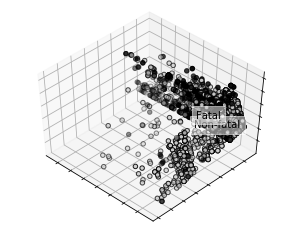

In [78]:
three_dee_pca_plotter(combo, exp3_labels, [('Non-fatal', 0), ('Fatal', 1)])

In [60]:
# experiment 3
print(history.history["acc"][-1], history.history["val_acc"][-1])
exp3_acc = 0.919
exp3_val_acc = 0.778

0.919013062496 0.778067879204


In [82]:
# experiment 4 - upped the dropout rate (to 60% from 50%), increased the validation set size (to 20% from 10%)
print(history.history["acc"][-1], history.history["val_acc"][-1])
exp4_acc = 0.943
exp4_val_acc = 0.778

0.942847811382 0.778067882005


In [86]:
# experiment 5 - removed two of the conv layers and a max pool layer to simplify model/reduce number of params
# did reduce overfitting a bit (accuracy on training and validation converged a little more)
print(history.history["acc"][-1], history.history["val_acc"][-1])
exp5_acc = 0.874
exp5_val_acc = 0.807

0.873938601209 0.806788513928


## NLP - Column Entry Clustering, Word Distances and Sentence Embeddings 

Several of the columns in the dataset contain rich text with meaningful information that would likely provide interesting and predictive features. However, at the moment, that data is either simplified away (by pre-processing and aggregation like the Species and ) or ignored due to complexity/variation (like the Area and Location data). This section will attempt to deal with this issues and incorporate as much information as possible into the feature set using several different methods.

In [62]:
def process(text):

    text = text.replace("\n", " ")
    
#     for char in ['!','?',',', ':', ';', '/','(',')', '\\', '-', ']', '[']:
#         text = text.replace(char, "")
    
    words = text.split(' ')
    for i in range(len(words)):
        w = words[i]
        try:
            float(w)
        except:
            words[i] = words[i].replace('.', "")
    text = " ".join(words)
    text = text.lower()
    return text

process('This is some, broken! dTEKJFDSXT//? 2.5, 1abc.24')

'this is some, broken! dtekjfdsxt//? 25, 1abc24'

In [63]:
free_text_cols = data_useful_cols[['Location', 'Area', 'Species ', 'Activity']]
free_text_cols = free_text_cols.fillna('Unknown')

In [111]:
# tokenise the columns

# load GloVE
glove = open('../glove.6B.200d.txt').readlines()
glove_embeddings = {}
for line in glove:
    line = line.replace("'", "").replace("\n", "")
    parts = line.split(' ')
    glove_embeddings[parts[0]] = np.array([float(p) for p in parts[1:]])

In [149]:
bag_of_words = {}
bag_of_words["<PAD>"] = 0
ind = 1
for c in free_text_cols.columns:
    for r in free_text_cols[c]:
        r = process(r)
        words = r.split(' ')
        for w in words:
            if not bag_of_words.get(w, None):
                bag_of_words[w] = ind
                ind += 1

bag_of_words["<UNK>"] = ind


In [156]:
print(len(bag_of_words.keys()))
wrd_count = 0
for k in bag_of_words.keys():
    try:
        glove_embeddings[k]
    except:
        wrd_count += 1

print(f"{round(wrd_count/len(bag_of_words.keys())*100)}% of words are missing from GLoVE")

6673
25% of words are missing from GLoVE


In [176]:
glove_embeddings = {}
glove = []

In [1]:
import spacy
import tensorflow_hub as hub


ImportError: cannot import name 'abs'

In [ ]:
nlp = spacy.load('en_core_web_md')

In [66]:
text_doc = "" # this will be where we add all the row entries per column as 'sentences'
for index, row in free_text_cols.iterrows():
    for c in ['Location', 'Area', 'Species ', 'Activity']:
        entry = row[c]
        entry = entry.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0',' ') #get rid of problem chars
        entry = ' '.join(entry.split()) #a quick way of removing excess whitespace
        entry = process(entry)
        text_doc += entry
        if c != 'Activity':
            text_doc += ', '
    text_doc += '. '

In [67]:
#text represents our raw text document

doc = nlp(text_doc)
sentences = []
for i in doc.sents:
    if len(i) > 1:
        sentences.append(i.string.strip()) #tokenize into sentences

In [68]:
# Get the ELMo model
url = "https://tfhub.dev/google/elmo/2"
embed = hub.Module(url)

NameError: name 'hub' is not defined